Import sqlite3, pandas, matplotlib.pyplot, seaborn, and reduce from functools. Then run '%matplotlib inline' in order to make plots visible in the notebook.

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
%matplotlib inline

Connect to crash-data.db with sqlite3. Query crashes from table 'crashes' only rows where Motorcycle Count is greater than 0. Export that query to a pandas DataFrame called 'mc_df' (Motorcycle Crashes Data Frame).

In [2]:
sql_query1 = ('SELECT * FROM crashes '
              'WHERE "motorcycle count" > 0')
conn = sql.connect('crash-data.db')
mc_df = pd.read_sql_query(sql_query1, conn)
conn.close()

Create a new DataFrame called 'by_county1', using the mc_df retrieved from the database. Use groupby to count the number of motorcyle crashes by county. Rename the columns and add a % to total Crashes column.

In [3]:
by_county1 = pd.DataFrame(mc_df.groupby('County Name')['Crash Record Number'].count()).reset_index(level=0)
by_county1.rename(columns={'County Name': 'CTYName', 'Crash Record Number': 'CrashCount'}, inplace=True)
by_county1['Crash%'] = by_county1['CrashCount'] / by_county1['CrashCount'].sum()

Connect to the database again to get PA County Population Data. Export that data into a pandas DataFrame called 'pop_df'.

In [4]:
sql_query2 = ('SELECT CTYNAME, Pop FROM PA_County_Population ')
conn = sql.connect('crash-data.db')
pop_df = pd.read_sql_query(sql_query2, conn)
conn.close()

Clean up the County Name column, and rename it to match the other DataFrames. This column will be used as a key when we go to merge the DataFrames. Add a % to total population column.

In [5]:
pop_df['CTYNAME'] = pop_df['CTYNAME'].apply(lambda x: x.split(' ')[0]).replace({'Mckean': 'McKean'})
pop_df['Pop'] = pop_df['Pop'].astype(int)
pop_df['Pop%'] = pop_df['Pop'] / pop_df['Pop'].sum()
pop_df.rename(columns={'CTYNAME': 'CTYName'}, inplace=True)

Connect to the database and get total linear road miles for each county. Export that query to a DataFrame called 'lm_df' (linear miles data frame).

In [6]:
sql_query3 = ('SELECT COUNTY, "TOTAL LINEAR MILES" FROM PA_County_LinearMiles ')
conn = sql.connect('crash-data.db')
lm_df = pd.read_sql_query(sql_query3, conn)
conn.close()

Clean up the County Name column and make the header match the other DataFrames. Drop the 'TOTAL' row at the bottom. Make a % to total linear miles by county column.

In [7]:
lm_df.rename(columns={'COUNTY': 'CTYName', 'TOTAL LINEAR MILES': 'LinearMiles'}, inplace=True)
lm_df.drop(lm_df[lm_df.CTYName == 'TOTAL'].index, inplace=True)
lm_df['CTYName'] = lm_df['CTYName'].apply(lambda x: x.split()[1].lower().title()).replace({'Mckean': 'McKean'})
lm_df['LinearMiles'] = lm_df['LinearMiles'].apply(lambda x: x.replace(",", "")).astype(float)
lm_df['LinearMiles%'] = lm_df['LinearMiles'] / lm_df['LinearMiles'].sum()

Last time connecting to the database. Grab the DVMT (Daily Vehicle Miles Traveled) information from the table, PA_County_DVMT. Export it into a DataFrame called 'dvmt_df'.

In [8]:
sql_query4 = ('SELECT COUNTY, "TOTAL DVMT" FROM PA_County_DVMT ')
conn = sql.connect('crash-data.db')
dvmt_df = pd.read_sql_query(sql_query4, conn)
conn.close()

Clean up the County Name column, rename it, and add a % to total DVMT by county column.

In [9]:
dvmt_df.rename(columns={'COUNTY': 'CTYName', 'TOTAL DVMT': 'DVMT'}, inplace=True)
dvmt_df.drop(dvmt_df[dvmt_df['CTYName'] == 'TOTAL'].index, inplace=True)
dvmt_df['CTYName'] = dvmt_df['CTYName'].apply(lambda x: x.split()[1].lower().title()).replace({'Mckean': 'McKean'})
dvmt_df['DVMT'] = dvmt_df['DVMT'].apply(lambda x: x.replace(",", "")).astype(float)
dvmt_df['DVMT%'] = dvmt_df['DVMT'] / dvmt_df['DVMT'].sum()

Create a list of the DataFrames called dfs. Use the reduce function to merge each one in sequence on the 'CTYName' column. Now we have a DataFrame that has the number of crashes, population, linear miles, and DVMT by county as well as a % to total for each.

In [10]:
dfs = [by_county1, pop_df, lm_df, dvmt_df]
county_df = reduce(lambda x, y: pd.merge(x, y, on='CTYName'), dfs)

I want to view a bar plot with each county and the % to total for each variable. Seaborn as an argument called 'hue' that makes it easy to accomplish. We need to format the DataFrame a little differently though to make this happen. Use the following code to reformat it so we have a column for County Name, %, and Metric.
* A warning message with output, due to us copying over a slice of the DataFrame. This is ok, since we are copying over a new DataFrame and not the original.

In [11]:
dfs2 = []
columns = ['Crash%', 'Pop%', 'LinearMiles%', 'DVMT%']
for i in columns:
    new_df = county_df[['CTYName', i]]
    new_df['Metric'] = i
    new_df.rename(columns={i: '%'}, inplace=True)
    dfs2.append(new_df)
county_plot = reduce(lambda x, y: pd.concat([x, y], ignore_index=True), dfs2)

/home/michaelpfredericks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/michaelpfredericks/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Create the bar plot with seaborn. This will show each county, and the % to total motorcycle crashes, population, linear miles, and DVMT.

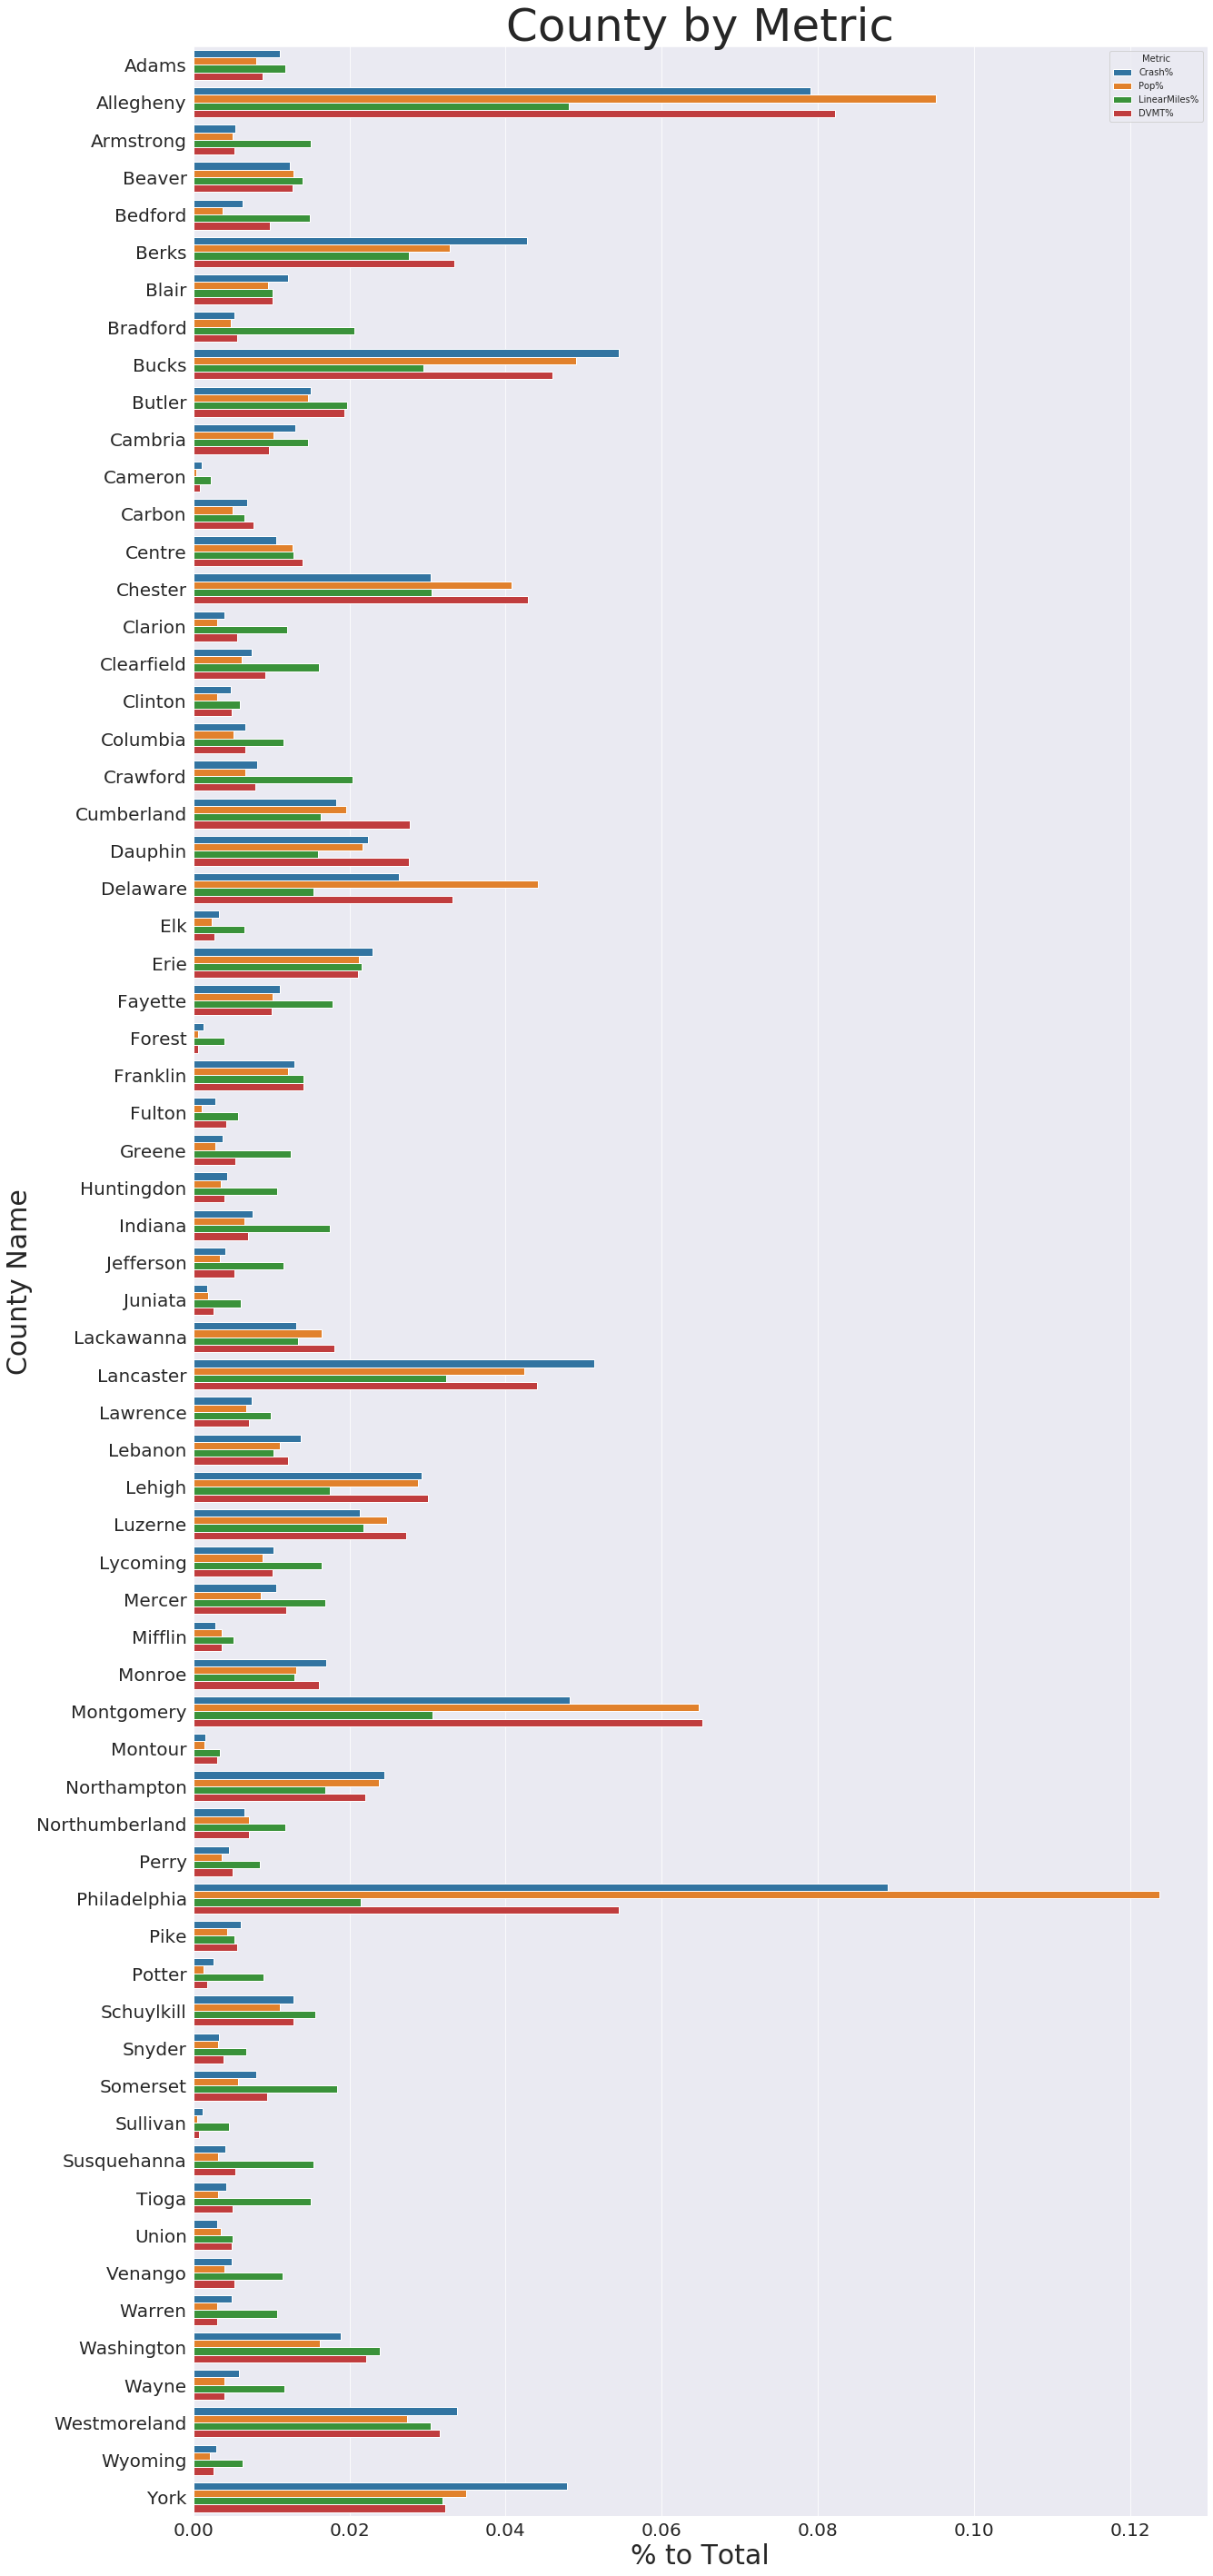

In [12]:
plt.figure(figsize=(20,50))
sns.set_style('darkgrid')
sns.barplot(x='%', y='CTYName', data=county_plot, hue='Metric')
plt.tick_params(labelsize=20)
plt.ylabel('County Name', fontsize=30)
plt.xlabel('% to Total', fontsize=30)
plt.title('County by Metric', fontsize=50)
plt.savefig('CountyByMetric.png')

It is interesting to note how some of these counties like Erie and Franklin have very similar % to total for each metric. Many, however have significant variation by metric. One noticible variation is the difference bewteen linear miles and DVMT. The areas with a higher % to total linear mileage than DVMT are typically going to be your more rural areas, whereas the opposite will be a good indication of an urban area. More directly, the comparision between the two is a good measure of traffic or congestion.

---

In order to compare the congestion of each counties roadways, we must create a relative index. One way to do this is to find the Daily Vehicle Mile Travel by a single linear mile. Divide the DVMT by linear miles to get this. Then divide each county's results by an average of the results to get a relative index. We will call this the 'Congestion-Index'

To measure the likelyhood of motorcycle crashes by county, we need to also take into account the DVMT for each county. We create another index called the 'DVMTCrash-Index' that will look at the variation in % to total motorcycle crashes and % to total DVMT. For this, we take the (DVMT% - Crash%) / DVMT%. An index value greater than 0 will show that there are less motorcycle crashes per daily vehilce mile driven than the baseline, whereas a negative index value will show more crashes per daily vehicle mile driven than the baseline.

In [13]:
county_df['Congestion'] = county_df['DVMT'] / county_df['LinearMiles']
county_df['Congestion-Index'] = county_df['Congestion'] / county_df['Congestion'].mean()
county_df['DVMTCrash-Index'] = (county_df['DVMT%'] - county_df['Crash%'])/county_df['DVMT%']
county_df['Congestion-Index Formatted'] = county_df['Congestion-Index'].round(2).astype(str)
county_df['CTYName : Congestion-Index'] = county_df['CTYName'] + ' : ' + county_df['Congestion-Index Formatted']
county_df.drop('Congestion-Index Formatted', axis=1, inplace=True)

Make a simple visual representation of both the Congestion-Index and the DVMTCrash-Index. A barplot will show the DVMTCrash-Index and the y-axis of that same plot will contain the Congestion-Index of the county next to the label.

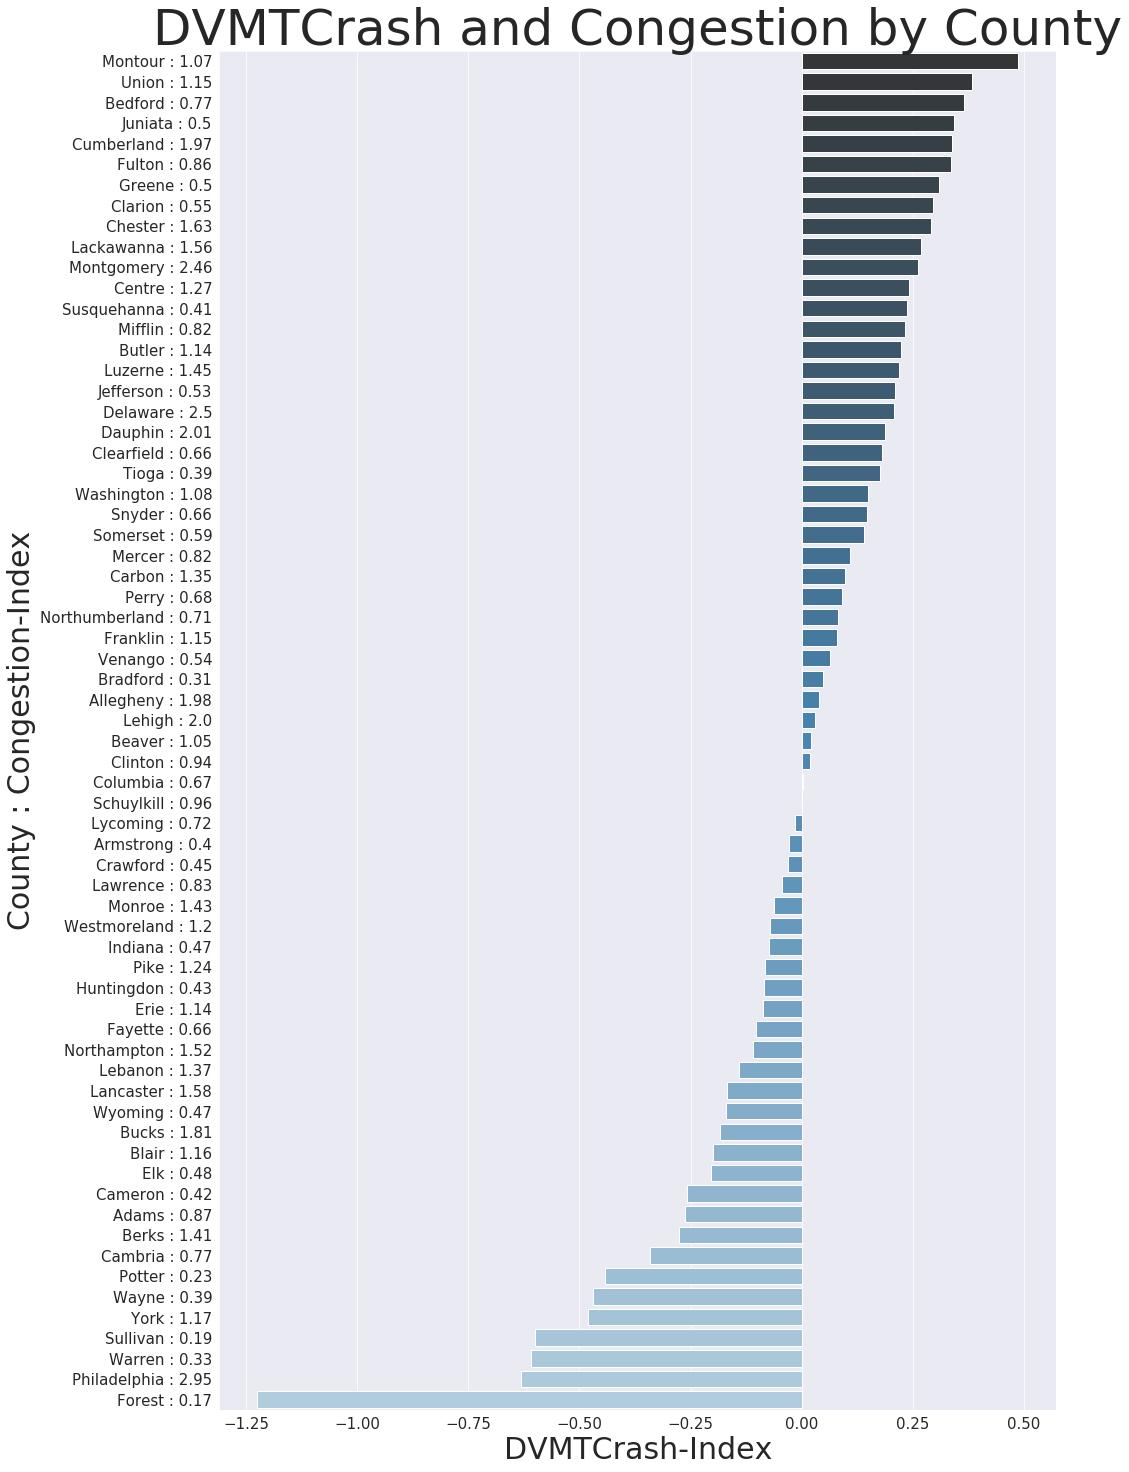

In [14]:
plt.figure(figsize=(15,25))
plt.tick_params(labelsize=15)
sns.barplot(x='DVMTCrash-Index', y='CTYName : Congestion-Index', data=county_df.sort_values('DVMTCrash-Index', ascending=False), palette='Blues_d')
plt.title('DVMTCrash and Congestion by County', fontsize=50)
plt.xlabel('DVMTCrash-Index', fontsize=30)
plt.ylabel('County : Congestion-Index', fontsize=30)
plt.savefig('DVMTCrashCongestionIndicis.png')

Philadephia, Allegheny, and Montgomery County all have high Congestion-Index values (2.95, 1.98, and 2.46 respectively). Each fall in very differnt places on the DVMT/Crash-Index. Philadelphia has the second most motorcyle crashes per daily vehicle mile driven, Allegheny sits right above the baseline, and Montgomery sits up there in there in the higher portion of the DVMTCrash-Index.

---